### Section 3: Data Modelling | Recommender system | Matrix Factorization with PyTorch

**Objective: **Imagine you have been tasked to build a recommendation system. Some training data is available at https://goo.gl/mHPsHM. The user-item ratings are in the form of {1, 2, 3, 4} s.t. 1=Hate, 2=Dislike, 3=Like, 4=Love. You have the option of treating this problem as either a regression- or multi-class classification-problem. The end goal is to develop a system which takes the user attributes as input and outputs the user-item rating.

#### Approach

First, a basic MF model, based on 50-factors Embeddings layers, was implemented. On top of it different things were tested:

1. Adding users profile information. A common approach would be to use this data to calculate the distance or similarity matrix between users before applying a clustering algorithm in collaborative filtering. 

In this case, the users profile data (binary), was used as a multiplicative factor to the embedded user matrix (which was forced to have the same dimensions as the user | items embeddings). This intuitively 'imposses' the profile data as the user embedding matrix.

2. Small and bigger Embedding layers -number of factors: [1, 5, 10, 20, 50, 100, 200]

3. Batch Normalization layers previous and after the Embeddings layers 

4. ReLU and Dropout layers after the user and item Embedding layers.

5. Sigmoid function to the (matrix multiplication) end result, and normalization of the output based on min max rating values.

#### Comments and results

**Architecture**
- In intermediate training experiments (not so noticeable in the last configuration):
    - Dropout reduced the convergence time significantly.
    - Low batch sizes and high lr also helped, specially with SGD.

- Adding the user profile data also reduces the loss
- Sigmoid function reduces the loss
- Adding a 1d BatchNormalization layer between the Embedding and RELU layers slightly improves the accuracy as well.

**Training**
- Interesting the curve of validation accuracy vs batch size with a lr = 0.01
- Optimizers tested: SGD, SparseAdam, Adagrad. SparseAdam outperformed the others in the final implementation (with RELU and Dropout layers)
- With this depth (layers), the size of the embedding layers seems to not affect the accuracy: 
    - tested [1, 5, 10, 20, 50, 100, 200] factors | best acc.: 50 factors + user profiles
    
**Results**

Best RMSE accuracies:
   - MF implementation: 0.76
   - MF implementation (using user-profile data): 0.63
   - Spotlight MF implementation: 0.86
   - Surprise KNN, SVD and MF implemtations: 0.79, 0.68, 2.16

### Matrix Factorization

In [4]:
import torch
import torchvision
import numpy as np
import pandas as pd
import random, math
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# just for reference:

loss_functions = [
    torch.nn.BCEWithLogitsLoss,
    torch.nn.CosineEmbeddingLoss,
    torch.nn.CosineSimilarity,
    torch.nn.CrossEntropyLoss,
    torch.nn.HingeEmbeddingLoss,
    torch.nn.KLDivLoss,
    torch.nn.L1Loss,
    torch.nn.MSELoss,
    torch.nn.MarginRankingLoss,
    torch.nn.MultiLabelMarginLoss,
    torch.nn.MultiLabelSoftMarginLoss,
    torch.nn.MultiMarginLoss,
    torch.nn.NLLLoss,
    torch.nn.NLLLoss2d,
    torch.nn.PoissonNLLLoss,
    torch.nn.SmoothL1Loss,
    torch.nn.SoftMarginLoss,
    torch.nn.TripletMarginLoss
]

optimizers = [
    torch.optim.SGD,
    torch.optim.SparseAdam,
    torch.optim.Adagrad,
    torch.optim.SparseAdam
]

In [24]:
from torch.utils.data import DataLoader, Dataset

class UserItemInteractionsDataset(Dataset):
    def __init__(self, inters_sparse_matrix, mode, v=True):
        super().__init__()
        """
        'ix', 'ixs' and 'v' stand for index and value
        """
        self.inters = inters_sparse_matrix
        self.mode = mode
        
        # retrieve ratings indexes
        users_ixs, items_ixs = inters_sparse_matrix.nonzero()
        n_users, n_items, n_inters = len(np.unique(users_ixs)), len(np.unique(items_ixs)), len(users_ixs)

        self.data = {'users_ixs': users_ixs, 'items_ixs' : items_ixs}
    
        # shuffle and split data
        ss_ix = np.random.permutation(n_inters)
        ss_ixs = {'train': ss_ix[:len(ss_ix) * 3 // 5], 
                  'eval': ss_ix[len(ss_ix) * 3 // 5: len(ss_ix) * 4 // 5],
                  'test': ss_ix[len(ss_ix) * 4 // 5:]}
        
        self.dataset = {i: j[ss_ixs[mode]] for i, j in self.data.items()}
        self.dataset_size =  len(ss_ixs[mode])

        if v: print('Setting "%s" dataset with %d users, %d items and %d interactions' %(mode, 
                                                                                len(np.unique(self.dataset['users_ixs'])),
                                                                                len(np.unique(self.dataset['items_ixs'])),
                                                                                len(ss_ixs[mode])))
        
    def __getitem__(self, index):
        
        user_ix, item_ix = self.dataset['users_ixs'][index], self.dataset['items_ixs'][index]
                
        user_ix_tensor = Variable(torch.LongTensor([user_ix]))
        item_ix_tensor = Variable(torch.LongTensor([item_ix]))
        inter_v_tensor = Variable(torch.FloatTensor([self.inters[user_ix, item_ix]]))        
        
        return user_ix_tensor, item_ix_tensor, inter_v_tensor

    def __len__(self):
        return self.dataset_size
    

# example:
# print(dataset_ev.__getitem__(0))
# if we want to retrieve the original id number: users_ids[user_ix]

def train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=None, epochs=10, verbose=True):

    modes = ['train', 'eval']
    losses = {i: [] for i in modes}
    
    print('\nTraining...')
    for e in range(epochs):
        for mode in modes:
            if mode == 'train': model.train()
            elif mode == 'eval': model.eval()
            else: print('WRONG!')

            per_batch_losses = []
            for _, batch in enumerate(dataloaders[mode]): 

                # index of the sparse matrix
                user_ix, item_ix, inter_v = batch

                # predict
                inter_v_pred = model(user_ix, item_ix)
                loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

                per_batch_losses.append(loss.item())

                # backpropagate & update weights
                if mode == 'train': 
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss = np.asarray(per_batch_losses).mean()
            losses[mode].append(epoch_loss)
            
            if verbose:
                if mode == 'train': print('epoch: %d | training loss: %.2f | ' %(e, epoch_loss), end='')
                else: print('validation loss: %.2f' %epoch_loss)
            
        if scheduler: scheduler.step()
    
    return losses

def eval_model(dataloaders, model, optimizer, loss_fn=torch.nn.MSELoss(), epochs=1):
    
    losses = []
    
    for e in range(epochs):
        for mode in ['test']:
            
            model.eval()
            
            per_batch_losses = []
            for _, batch in enumerate(dataloaders[mode]): 

                # index of the sparse matrix
                user_ix, item_ix, inter_v = batch

                # predict
                inter_v_pred = model(user_ix, item_ix)
                loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

                per_batch_losses.append(loss.item())

        epoch_loss = np.asarray(per_batch_losses).mean()
        losses.append(epoch_loss)
        
    print('\n *** test loss: MSE %.2f | RMSE %.2f ***\n' %(np.asarray(losses).mean(), math.sqrt(np.asarray(losses).mean())))
                
def predict_item(model, datasets, loss_fn=torch.nn.MSELoss()):

    eg = random.randint(0, len(datasets['test']))

    user_ix, item_ix, inter_v = (i.unsqueeze(0) for i in datasets['test'].__getitem__(eg))
    inter_v_pred = model(user_ix, item_ix)
    loss = loss_fn(inter_v_pred.view(inter_v.shape), inter_v)

    print('Example [test dataset] - Predicted rating: %.2f | Rating: %.2f | Loss: MSE %.4f RMSE: %.4f' 
          %(inter_v_pred, inter_v, loss, math.sqrt(loss)))
    

In [25]:
def load_data(load_upd=True):

    # Loading ratings data

    ratings = pd.read_csv('../data/recommender/user_item_ratings.csv')
    ratings_pt = pd.pivot_table(ratings, index=['UserID'], columns=['ItemID'], fill_value=0, dropna=True)

    sparse_ratings = ratings_pt.values

    users_ids = np.unique(ratings['UserID'])
    items_ids = np.unique(ratings['ItemID'])
    n_users, n_items, n_atts = len(users_ids), len(items_ids), None

    if load_upd:
        
        # Loading user profiles data

        user_profiles = pd.read_csv('../data/recommender/user_attributes.csv', index_col=0).values
        n_users_profiles, n_atts = user_profiles.shape[0], user_profiles.shape[1]
        assert n_users == n_users_profiles

    print('Interaction matrix of %d users and %d items | Num. of interactions: %d | Num. of attributes per user: %s\n' 
          %(n_users, n_items, len(sparse_ratings.nonzero()[0]), str(n_atts)), end='')
    
    conf_file = {}
    conf_file['n_users'] = n_users
    conf_file['n_items'] = n_items
    conf_file['n_factors'] = n_atts
    
    return sparse_ratings, user_profiles if load_upd else None, conf_file

def load_movielens_data(): # not used - for benchmarking with movielens challenge

    # Loading ratings data

    ratings = pd.read_csv('ml-latest-small/ratings.csv') # reading data in pandas df
    ratings_pt = pd.pivot_table(ratings, values=['rating'], index=['userId'], columns=['movieId'], fill_value=0)

    sparse_ratings = ratings_pt.values

    users_ids = np.unique(ratings['userId'])
    items_ids = np.unique(ratings['movieId'])
    n_users, n_items, n_atts = len(users_ids), len(items_ids), None

    print('Interaction matrix of %d users and %d items | Num. of attributes per user: %d' 
          %(n_users, n_items, n_atts), end='')
    
    conf_file = {}
    conf_file['n_users'] = n_users
    conf_file['n_items'] = n_items
    conf_file['n_factors'] = n_atts
    
    return sparse_ratings, None, conf_file

In [181]:
class BasicBiasedMatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        self.user_biases = torch.nn.Embedding(n_users, 1, sparse=True)
        self.item_biases = torch.nn.Embedding(n_items, 1, sparse=True)
      
    def forward(self, user, item):
        pred = (self.user_biases(user) + self.item_biases(item)).view((self.user_factors(user) * self.item_factors(item)).sum(-1).shape)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(-1)
        return pred

class BiasedMatrixFactorization(torch.nn.Module):
    
    def __init__(self, conf_file, user_profiles=None, p_drop=0., sig=True, use_fc=False):
        super().__init__()
        
        n_users, n_items, n_factors = conf_file['n_users'], conf_file['n_items'], conf_file['n_factors']
        
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=False)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=False)
        self.user_biases = torch.nn.Embedding(n_users, 1, sparse=True)
        self.item_biases = torch.nn.Embedding(n_items, 1, sparse=True)
        
        self.use_fc = use_fc
        self.fc = torch.nn.Linear(n_factors, 1)
#         self.fc = torch.nn.Embedding(1, n_factors, sparse=True)
        
        self.dropout = torch.nn.Dropout(p=p_drop)

        if sig: self.sigmoid = torch.nn.Sigmoid()
        else: self.sigmoid = False
            
        self.user_profiles = user_profiles
        if user_profiles is not None: 
            assert n_factors == user_profiles.shape[1]
      
    def forward(self, user, item, max_v=4., min_v=1.):
        
        if self.user_profiles is not None: 
            user_profiles = torch.FloatTensor(self.user_profiles)
            ufs = user_profiles[user] * torch.nn.ReLU()((self.user_factors(user)))
        else: 
            ufs = self.dropout(torch.nn.ReLU()((self.user_factors(user))))
        ifs = self.dropout(torch.nn.ReLU()((self.item_factors(item))))
        
        if self.use_fc: 
            pred = self.fc (ufs * ifs)
#             pred = ufs * ifs
#             pred = self.fc(torch.LongTensor([0])) * pred
#             pred = pred.sum(-1)
#             pred += (self.user_biases(user) + self.item_biases(item)).view(pred.shape)
        else:
            pred = (ufs * ifs).sum(-1)
            pred += (self.user_biases(user) + self.item_biases(item)).view(pred.shape)
        
        if self.sigmoid: pred = self.sigmoid(pred) * (max_v - min_v) + min_v
        
        return pred

Interaction matrix of 1912 users and 805 items | Num. of interactions: 29464 | Num. of attributes per user: 50
Setting "train" dataset with 1851 users, 805 items and 17678 interactions
Setting "eval" dataset with 1604 users, 800 items and 5893 interactions
Setting "test" dataset with 1588 users, 795 items and 5893 interactions

Training...
epoch: 0 | training loss: 0.78 | validation loss: 0.71
epoch: 1 | training loss: 0.68 | validation loss: 0.67
epoch: 2 | training loss: 0.64 | validation loss: 0.64
epoch: 3 | training loss: 0.61 | validation loss: 0.63
epoch: 4 | training loss: 0.59 | validation loss: 0.61
epoch: 5 | training loss: 0.57 | validation loss: 0.60
epoch: 6 | training loss: 0.55 | validation loss: 0.58
epoch: 7 | training loss: 0.53 | validation loss: 0.57
epoch: 8 | training loss: 0.50 | validation loss: 0.55
epoch: 9 | training loss: 0.48 | validation loss: 0.53

 *** test loss: MSE 0.52 | RMSE 0.72 ***

Example [test dataset] - Predicted rating: 3.08 | Rating: 4.00 | 

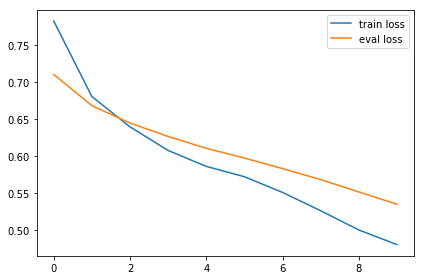

In [182]:
if True:
    epochs = 10
    modes = ['train', 'eval', 'test']
    
    sparse_ratings, user_profiles, conf_file = load_data()

    datasets = {i: UserItemInteractionsDataset(sparse_ratings, i) for i in modes}
    dataloaders = {i: DataLoader(datasets[i], batch_size=1024, shuffle=True, num_workers=0) for i in modes}

    loss_fn = torch.nn.MSELoss() 
    model = BiasedMatrixFactorization(conf_file, user_profiles=user_profiles, p_drop=0., use_fc=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
    
    losses = train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=None, epochs=epochs, verbose=1)
    eval_model(dataloaders, model, optimizer)
    
    import matplotlib.pyplot as plt

    plt.plot(losses['train'])
    plt.plot(losses['eval'])
    plt.tight_layout() 
    plt.legend(['train loss', 'eval loss'])
    
    predict_item(model, datasets)

In [84]:
### DONOTTOUCH

Interaction matrix of 1912 users and 805 items | Num. of interactions: 29464 | Num. of attributes per user: 50
Setting "train" dataset with 1853 users, 805 items and 17678 interactions
Setting "eval" dataset with 1610 users, 798 items and 5893 interactions
Setting "test" dataset with 1609 users, 801 items and 5893 interactions

Training...
epoch: 0 | training loss: 1.28 | validation loss: 1.20
epoch: 1 | training loss: 1.16 | validation loss: 1.11
epoch: 2 | training loss: 1.06 | validation loss: 1.02
epoch: 3 | training loss: 0.96 | validation loss: 0.94
epoch: 4 | training loss: 0.86 | validation loss: 0.86
epoch: 5 | training loss: 0.77 | validation loss: 0.79
epoch: 6 | training loss: 0.69 | validation loss: 0.73
epoch: 7 | training loss: 0.62 | validation loss: 0.68
epoch: 8 | training loss: 0.55 | validation loss: 0.64
epoch: 9 | training loss: 0.50 | validation loss: 0.60
epoch: 10 | training loss: 0.46 | validation loss: 0.57
epoch: 11 | training loss: 0.42 | validation loss: 0

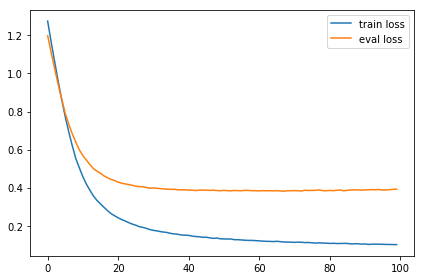

In [57]:
def main():
    epochs = 100
    modes = ['train', 'eval', 'test']
    
    sparse_ratings, user_profiles, conf_file = load_data()

    datasets = {i: UserItemInteractionsDataset(sparse_ratings, i) for i in modes}
    dataloaders = {i: DataLoader(datasets[i], batch_size=1024, shuffle=True, num_workers=0) for i in modes}

    loss_fn = torch.nn.MSELoss() 
    model = BiasedMatrixFactorization(conf_file, user_profiles=user_profiles, p_drop=0., use_fc=0)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-2)
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
    
    losses = train_and_eval_model(dataloaders, model, optimizer, loss_fn, scheduler=None, epochs=epochs, verbose=1)
    eval_model(dataloaders, model, optimizer)
    
    import matplotlib.pyplot as plt

    plt.plot(losses['train'])
    plt.plot(losses['eval'])
    plt.tight_layout() 
    plt.legend(['train loss', 'eval loss'])
    
    predict_item(model, datasets)
    
main()

#### Experiments

In [63]:
def main_with_experiments():
    epochs = 100
    modes = ['train', 'eval', 'test']
    settings = {
            'n_factors': [50, 200, 400], #[1, 5, 10, 20, 50, 100, 200, 500],
            'batch_size': [32, 512, 1024],
        }

    sparse_ratings, user_profiles, conf_file = load_data(load_upd=False)

    for i in settings: conf_file[i] = settings[i][0]
    
    results = {}

    for i in settings.keys():
        
        print('Sensitivity to %s' %i)
        
        series = {} #str(i): [] for i in n_factors_list}
        for value in settings[i]:

            conf_file[i] = value; print(conf_file)

            datasets = {i: UserItemInteractionsDataset(sparse_ratings, i, v=False) for i in modes}
            dataloaders = {i: DataLoader(datasets[i], batch_size=conf_file['batch_size'], shuffle=True, num_workers=0) for i in modes}

            loss_fn = torch.nn.MSELoss() 
            model = BiasedMatrixFactorization(conf_file, user_profiles=user_profiles, p_drop=0., sig=True)
            optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-3)
        #     torch.optim.SGD(model.parameters(), lr=1e-1)

            losses = train_and_eval_model(dataloaders, model, optimizer, loss_fn, epochs=epochs, verbose=False)
            eval_model(dataloaders, model, optimizer)

            series[str(value)] = losses['eval']
        
        conf_file[i] = settings[i][0]
        results[i] = series
        
    return results

resulst = main_with_experiments()

Interaction matrix of 1912 users and 805 items | Num. of attributes per user: None | Total num. of interactions: 29464
Sensitivity to n_factors
{'n_users': 1912, 'n_items': 805, 'n_factors': 50, 'batch_size': 32}
Setting "train" dataset with 1850 users, 805 items and 17678 interactions
Setting "eval" dataset with 1602 users, 800 items and 5893 interactions
Setting "test" dataset with 1594 users, 802 items and 5893 interactions

Training...

 *** test loss: MSE 0.44 | RMSE 0.66 ***
{'n_users': 1912, 'n_items': 805, 'n_factors': 200, 'batch_size': 32}
Setting "train" dataset with 1853 users, 805 items and 17678 interactions
Setting "eval" dataset with 1612 users, 796 items and 5893 interactions
Setting "test" dataset with 1608 users, 800 items and 5893 interactions

Training...

 *** test loss: MSE 1.17 | RMSE 1.08 ***
{'n_users': 1912, 'n_items': 805, 'n_factors': 400, 'batch_size': 32}
Setting "train" dataset with 1867 users, 805 items and 17678 interactions
Setting "eval" dataset with

Interaction matrix of 1912 users and 805 items | Num. of interactions: 29464 | Num. of attributes per user: 50
Setting "train" dataset with 1838 users, 805 items and 17678 interactions
Setting "eval" dataset with 1595 users, 799 items and 5893 interactions
Setting "test" dataset with 1600 users, 800 items and 5893 interactions

Training...
epoch: 0 | training loss: 1.10 | validation loss: 0.78
epoch: 1 | training loss: 0.56 | validation loss: 0.53
epoch: 2 | training loss: 0.37 | validation loss: 0.45
epoch: 3 | training loss: 0.27 | validation loss: 0.42
epoch: 4 | training loss: 0.23 | validation loss: 0.40
epoch: 5 | training loss: 0.20 | validation loss: 0.39
epoch: 6 | training loss: 0.18 | validation loss: 0.39
epoch: 7 | training loss: 0.18 | validation loss: 0.39
epoch: 8 | training loss: 0.17 | validation loss: 0.39
epoch: 9 | training loss: 0.16 | validation loss: 0.38
epoch: 10 | training loss: 0.16 | validation loss: 0.39
epoch: 11 | training loss: 0.16 | validation loss: 0

KeyboardInterrupt: 

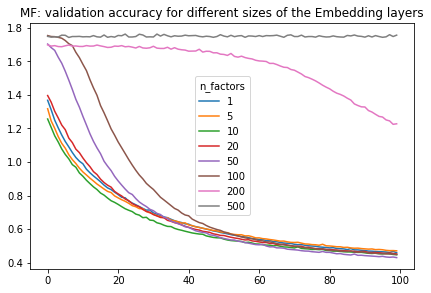

In [61]:
# plotting the experiment results
for i in results.keys():
    if len (results[i].keys()) == 1: continue
    for j in results[i].keys():
        plt.plot(results[i][j])
        plt.tight_layout() 
    plt.legend([str(j) for j in results[i].keys()], title=i)
    plt.title('MF: validation accuracy for different sizes of the Embedding layers')

which = 'n_factors'
plot_results(results, which)

In [62]:
# which = 'batch_size'
# plot_results(results, which)
results

{'n_factors': {'1': [1.36762854344136,
   1.3110974640459627,
   1.2496583616411363,
   1.2035968155474277,
   1.1607685959016956,
   1.1223485891883438,
   1.0902764644171741,
   1.0566839195586539,
   1.0271722527774605,
   1.0049776132042343,
   0.98940247764458522,
   0.95706490310462744,
   0.93590364166208218,
   0.91716784432127674,
   0.90010289549827571,
   0.88235363766953756,
   0.86239064368041785,
   0.84595461213910905,
   0.83602946771157749,
   0.82038776407370695,
   0.8059794575781436,
   0.79005527995728153,
   0.78684756643063314,
   0.76705966446850748,
   0.75564818833325365,
   0.74552488327026367,
   0.73467276821265348,
   0.72379634525324843,
   0.71367761480647163,
   0.71447175346516278,
   0.69659659347018676,
   0.6889763131334975,
   0.68088041109007758,
   0.67296073259534062,
   0.66814356897328353,
   0.65896529088149203,
   0.65039763043861132,
   0.64361490454222703,
   0.63955738214222158,
   0.63174011014603282,
   0.62987940843040879,
   0.6193966

#### Benchmarking results with Spotlight
Spotlight is a library, based on PyTorch, for shallow and deep recommender systems.
https://github.com/maciejkula/spotlight

In [75]:
import numpy as np
import torch
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.evaluation import rmse_score

In [76]:
ratings = pd.read_csv('../data/recommender/user_item_ratings.csv')
dataset = Interactions(np.asarray(ratings.UserID),#, dtype='float32'), 
                        np.asarray(ratings.ItemID),# dtype='float32'),
                        np.asarray(ratings.Rating, dtype='float32'))
print(dataset)
print(dataset.item_ids)
print(dataset.user_ids)
print(dataset.ratings, dataset.item_ids.dtype)

train, test = random_train_test_split(dataset, random_state=np.random.RandomState(42))
print('Split into: \n {} and \n {}.'.format(train, test))

<Interactions dataset (1912 users x 805 items x 29586 interactions)>
[194  96  34 ..., 538 132 281]
[   0    0    0 ..., 1911 1911 1911]
[ 3.  3.  4. ...,  4.  2.  3.] int64
Split into: 
 <Interactions dataset (1912 users x 805 items x 23668 interactions)> and 
 <Interactions dataset (1912 users x 805 items x 5918 interactions)>.


In [77]:
model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim=50,  # latent dimensionality
                                   n_iter=100,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   l2=1e-9,  # strength of L2 regularization
                                   learning_rate=1e-3,
                                   use_cuda=torch.cuda.is_available())

model.fit(train, verbose=True) 
train_rmse, test_rmse = rmse_score(model, train), rmse_score(model, test)
print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

Epoch 0: loss 9.387402137120565
Epoch 1: loss 9.15725588798523
Epoch 2: loss 8.96595593293508
Epoch 3: loss 8.742844700813293
Epoch 4: loss 8.436081369717916
Epoch 5: loss 8.057000736395517
Epoch 6: loss 7.499483863512675
Epoch 7: loss 6.733031809329987
Epoch 8: loss 5.775140980879466
Epoch 9: loss 4.7158472537994385
Epoch 10: loss 3.6491186320781708
Epoch 11: loss 2.7117698788642883
Epoch 12: loss 1.9679208596547444
Epoch 13: loss 1.3915416896343231
Epoch 14: loss 1.0158339018623035
Epoch 15: loss 0.7788159151872
Epoch 16: loss 0.6241805702447891
Epoch 17: loss 0.5261165301005045
Epoch 18: loss 0.46938345457116765
Epoch 19: loss 0.4328559848169486
Epoch 20: loss 0.4129755223790805
Epoch 21: loss 0.3885556509097417
Epoch 22: loss 0.37771720190842945
Epoch 23: loss 0.36308782920241356
Epoch 24: loss 0.35309917976458866
Epoch 25: loss 0.34613659232854843
Epoch 26: loss 0.33739593749245006
Epoch 27: loss 0.3323731906712055
Epoch 28: loss 0.3268224286536376
Epoch 29: loss 0.319390118122100

#### ...and Surprise packages

In [68]:
from surprise import Reader, Dataset
from surprise import evaluate
from surprise import NMF, SVD, KNNBasic 

In [74]:
ratings = pd.read_csv('../data/recommender/user_item_ratings.csv')

ratings_dict = {'itemID': list(ratings.ItemID),
                'userID': list(ratings.UserID),
                'rating': list(ratings.Rating)}

df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# Reader class used to parse a file containing ratings.
reader = Reader(rating_scale=(0.0, 5.0))

# Columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split data into 5 folds
data.split(n_folds=5)

# Model comparison

models = [
    SVD(),
    SVD(n_factors=50, n_epochs=100, biased=True),
    NMF(),
    NMF(n_factors=50, n_epochs=100, biased=True),
    KNNBasic()
]

for i in models:
    evaluate(i, data, measures=['rmse'], verbose=1)


/root/miniconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/root/miniconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.6752
------------
Fold 2
RMSE: 0.6681
------------
Fold 3
RMSE: 0.6773
------------
Fold 4
RMSE: 0.6705
------------
Fold 5
RMSE: 0.6621
------------
------------
Mean RMSE: 0.6706
------------
------------
Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.6772
------------
Fold 2
RMSE: 0.6848
------------
Fold 3
RMSE: 0.6947
------------
Fold 4
RMSE: 0.6857
------------
Fold 5
RMSE: 0.6706
------------
------------
Mean RMSE: 0.6826
------------
------------
Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 0.7312
------------
Fold 2
RMSE: 0.7406
------------
Fold 3
RMSE: 0.7380
------------
Fold 4
RMSE: 0.7409
------------
Fold 5
RMSE: 0.7214
------------
------------
Mean RMSE: 0.7344
------------
------------
Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 2.0919
------------
Fold 2
RMSE: 2.1427
------------
Fold 3
RMSE: 2.4282
------------
Fold 4
RMSE: 2.2903
------------
Fold 5
RMS